In [25]:
%matplotlib notebook
import time

import numpy as np
import matplotlib.pyplot as pl

import tacoma as tc
from tacoma.drawing import draw_edges
from tacoma.analysis import temporal_network_group_analysis
from tacoma.model_conversions import estimate_flockwork_P_args

# Load original network

In [26]:
socio = tc.load_sociopatterns_hypertext_2009()
socio_result = tc.measure_group_sizes_and_durations(socio)

# Simulate Flockworks accordingly

In [27]:
fwP_params = estimate_flockwork_P_args(socio,N_time_steps=100,aggregated_network=socio_result.aggregated_network)
fwP = tc.flockwork_P_varying_rates_neighbor_affinity(**fwP_params)
fwP_binned = tc.bin(fwP,dt=20)

# Set disease parameters

In [28]:
R0 = 2.0                  # number of secondary infections
rho = 1.0 / (24*3600.)    # recovery rate in 1/s
dt = 600                  # bin for sampling
t_simulation = 4*fwP.tmax # simulation_time
t_sample = np.arange(int(t_simulation / dt)+1,dtype=float) * dt 
N = socio.N

N_meas = 30 # measurements per network

# Simulate

<IPython.core.display.Javascript object>


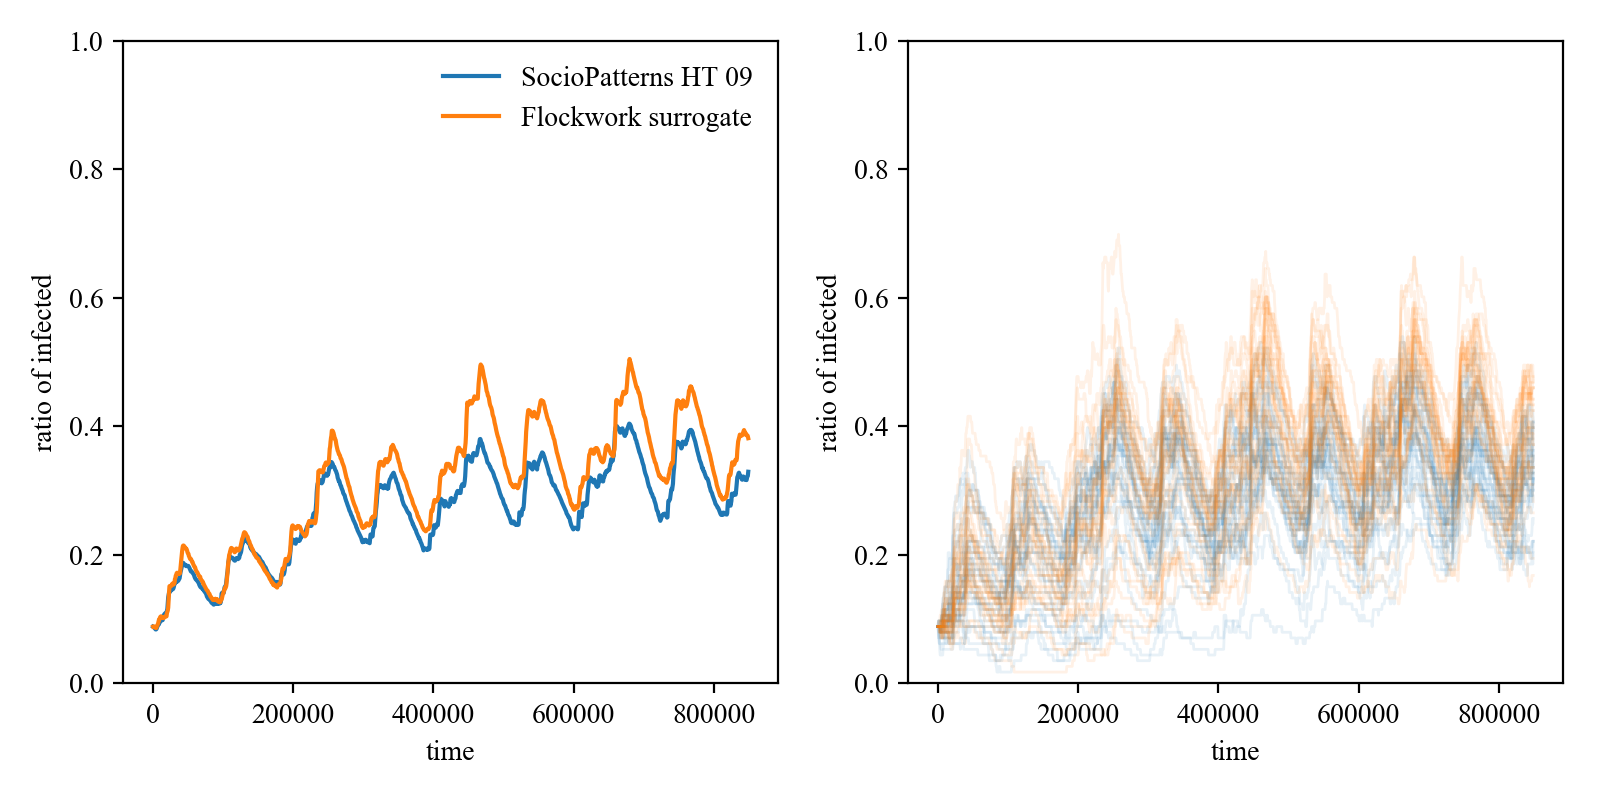

0.0005233058594638646
0.00038268759900221864


In [36]:
fig, ax = pl.subplots(1,2,figsize=(8,4))

labels = ['SocioPatterns HT 09', 'Flockwork surrogate' ]

for i_tn, tn in enumerate([socio, fwP_binned]):

    # compute the mean degree over the time
    t, k = np.array(tc.mean_degree(tn))
    mean_k = tc.time_average(t, k)    

    # compute the infection rate
    eta = R0 * rho / mean_k
    print eta
    
    # prepare the measured infected curve
    i_sample = np.zeros_like(t_sample)
    
    # count the samples where i(t_simulation) > 0
    succecssful_samples = 0

    for meas in range(N_meas):

        # prepare SIS object
        sis = tc.SIS(N, t_simulation, eta, rho, number_of_initially_infected = 10)

        # simulate SIS
        tc.gillespie_SIS(tn, sis)

        # get observables
        t = np.array(sis.time)
        i = np.array(sis.I,dtype=float) / N

        # sample from the observables
        this_sample = tc.sample_a_function(t,i,t_sample)
        
        # only count this if i(t_simulation) > 0
        if this_sample[-1] > 0.0:
            succecssful_samples += 1
            i_sample += this_sample
        
        # plot this single simulation        
        ax[1].plot(t_sample,this_sample,c=tc.color_sequence[i_tn],alpha=0.1,lw=1)

    # plot the mean of this simulation
    ax[0].plot(t_sample,i_sample/succecssful_samples,label=labels[i_tn])
    
ax[0].legend()    
ax[0].set_ylim([0,1])
ax[1].set_ylim([0,1])
ax[0].set_xlabel('time')
ax[0].set_ylabel('ratio of infected')
ax[1].set_xlabel('time')
ax[1].set_ylabel('ratio of infected')

fig.tight_layout()
fig.savefig("SIS_ht09_fw.pdf")

In [39]:
fwP.tmax/100

2123.6

In [6]:
socio

In [11]:
socio.

[0.0,
 20.0,
 40.0,
 60.0,
 80.0,
 100.0,
 120.0,
 140.0,
 160.0,
 180.0,
 200.0,
 220.0,
 240.0,
 260.0,
 280.0,
 300.0,
 320.0,
 340.0,
 360.0,
 380.0,
 400.0,
 420.0,
 440.0,
 460.0,
 480.0,
 500.0,
 520.0,
 540.0,
 560.0,
 580.0,
 600.0,
 620.0,
 640.0,
 660.0,
 680.0,
 700.0,
 720.0,
 740.0,
 760.0,
 780.0,
 800.0,
 820.0,
 840.0,
 860.0,
 880.0,
 900.0,
 920.0,
 940.0,
 960.0,
 980.0,
 1000.0,
 1020.0,
 1040.0,
 1060.0,
 1080.0,
 1100.0,
 1120.0,
 1140.0,
 1160.0,
 1180.0,
 1200.0,
 1220.0,
 1240.0,
 1260.0,
 1280.0,
 1300.0,
 1320.0,
 1340.0,
 1360.0,
 1380.0,
 1400.0,
 1420.0,
 1440.0,
 1460.0,
 1480.0,
 1500.0,
 1520.0,
 1540.0,
 1560.0,
 1580.0,
 1600.0,
 1620.0,
 1640.0,
 1660.0,
 1680.0,
 1700.0,
 1720.0,
 1740.0,
 1760.0,
 1780.0,
 1900.0,
 1920.0,
 1940.0,
 1960.0,
 1980.0,
 2000.0,
 2020.0,
 2040.0,
 2060.0,
 2080.0,
 2100.0,
 2120.0,
 2140.0,
 2160.0,
 2180.0,
 2200.0,
 2220.0,
 2240.0,
 2260.0,
 2280.0,
 2300.0,
 2320.0,
 2340.0,
 2360.0,
 2380.0,
 2400.0,
 2420.0,
 24

In [9]:
help(tc.flockwork_P_varying_rates_neighbor_affinity)

Help on built-in function flockwork_P_varying_rates_neighbor_affinity in module _tacoma:

flockwork_P_varying_rates_neighbor_affinity(...)
    flockwork_P_varying_rates_neighbor_affinity(E: List[Tuple[int, int]], N: int, P: List[float], t_run_total: float, rewiring_rate: List[Tuple[float, float]], neighbor_affinity: List[Tuple[List[int], List[float]]], tmax: float, use_random_rewiring: bool=False, equilibrate_flockwork: bool=False, use_preferential_node_selection: bool=False, use_unweighted_k_for_selection: bool=False, seed: int=0L) -> edge_changes
    
    Simulate a flockwork P-model given an initial state as an edge list with varying rewiring rate and varying P. Rewiring neighbors are chosen according to a neighbor affinity value. Returns time points and concurrent edge changes.



<IPython.core.display.Javascript object>


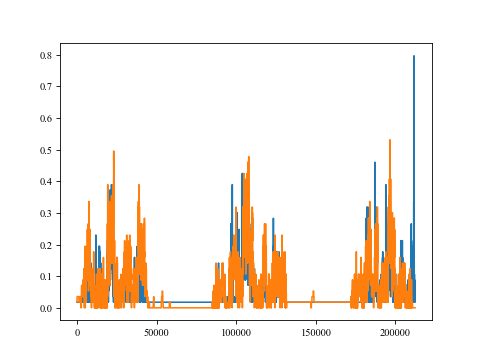

In [23]:
pl.figure()
t, k = tc.mean_degree(socio)
t_sample = np.linspace(t.min(), t.max(), 250)
pl.plot(t,k,'-')
t, k = tc.mean_degree(fwP_binned)
pl.plot(t,k,'-')

<IPython.core.display.Javascript object>


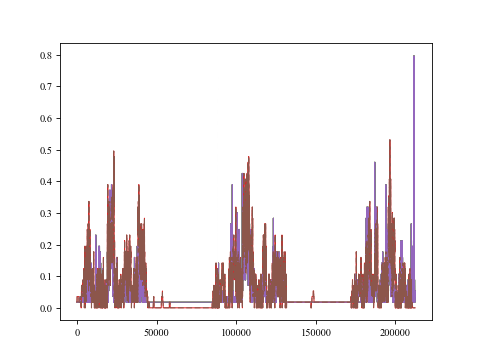